In [261]:
import zipfile
import shutil
import os

import cv2
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sklearn.metrics

use_graph = True

**Ссылка на датасет:**

https://www.kaggle.com/c/dogs-vs-cats/data 

Просто скачайте архивы и киньте в конель папки **data**

Можно это сделать через kaggle API, но тогда ещё заставлять вас там ключ API создавать... 
Поэтому просто авторизируйтесь на сайте, например, через Google, и скачайте датасет.

Для выполнения заданий, описанных ниже, использована модель, 
предварительно обученная на десяти тысячах изображений из датасета, 
рассмотренного в примере.

Для начала нужно считать саму нейронную сеть, благо в современном мире это делается крайне просто.

In [262]:
# Импортируем нужные библиотеки
import tensorflow as tf

# Вуаля, модель загружена.
with open('data/model/model_10k.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("data/model/Model_10k_images.h5")
print(f"Входной формат{model.input_shape}")
print(f"Выходной формат{model.output_shape}")
model.summary()

Входной формат(None, 150, 150, 3)
Выходной формат(None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_______________________________________________________________

###### 1. Отберите из тренировочного набора данных (файл train.zip) изображения с именами в диапазоне [cat.10900.jpg, cat.11000.jpg) и [dog.10900.jpg, dog.11000.jpg). Всего должно получиться по 100 изображений кошек и собак. Эти данные будут тестовыми.

In [263]:
zip_file = "data/train.zip"
shutil.rmtree("data/temp")
os.mkdir("data/temp")
os.mkdir("data/temp/cats")
os.mkdir("data/temp/dogs")
dataset_from = 10900
dataset_to = 11000
with zipfile.ZipFile(zip_file, 'r') as z:
    for i in range(dataset_from, dataset_to):
        z.extract(f"train/cat.{i}.jpg", "data/temp")
        os.replace(f"data/temp/train/cat.{i}.jpg",f"data/temp/cats/cat.{i}.jpg")
    for i in range(dataset_from, dataset_to):
        z.extract(f"train/dog.{i}.jpg", "data/temp")
        os.replace(f"data/temp/train/dog.{i}.jpg",f"data/temp/dogs/dog.{i}.jpg")
    shutil.rmtree("data/temp/train")

###### 2. Произведите оценку модели на отобранных тестовых данных:

Для это нужно понять, чем питаются нейронки

In [264]:
# Реализация считывания данных создателей курса. 
# Реализация через opencv или другие методы порождает другой датасет. 
# Данные отличаются незначительно, -2 порядок, но достаточно чтобы значительно исказить результаты классификации.
new_files_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
new_files_generator = new_files_datagen.flow_from_directory(
    "data/temp",
    target_size=(model.input_shape[1:3]),
    batch_size=200,
    class_mode='binary',
    shuffle=False
)
images, labels = new_files_generator.next()

Found 200 images belonging to 2 classes.


In [265]:
# Само предсказание осуществляется легко
predictions = model.predict(images)

In [266]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, np.round(np.array(predictions)))
print(f"Accuracy: {accuracy.result().numpy()}")

print(f"Precision (macro avg): {sklearn.metrics.precision_score(labels, np.round(np.array(predictions)), average='macro')}")

print(f"Recall (macro avg): {sklearn.metrics.recall_score(labels, np.round(np.array(predictions)), average='macro')}")

Accuracy: 0.7799999713897705
Precision (macro avg): 0.8003003003003003
Recall (macro avg): 0.78


###### 3. Выполните предсказания для следующих изображений.

cat.10908.jpg

и

dog.10908.jpg

Введите вероятность отнесения объекта своему классу: 

In [267]:
index = 10908 - dataset_from
print(f"Prediction for cat.{index + dataset_from}.jpg: {float('{:.2f}'.format(1 - model.predict(images[index : index + 1])[0][0]))}")
print(f"Prediction for dog.{index + dataset_from}.jpg: {float('{:.2f}'.format(model.predict(images[100 + index : 100 + index + 1])[0][0]))}")

Prediction for cat.10908.jpg: 0.36
Prediction for dog.10908.jpg: 0.19


cat.8.jpg
dog.8.jpg


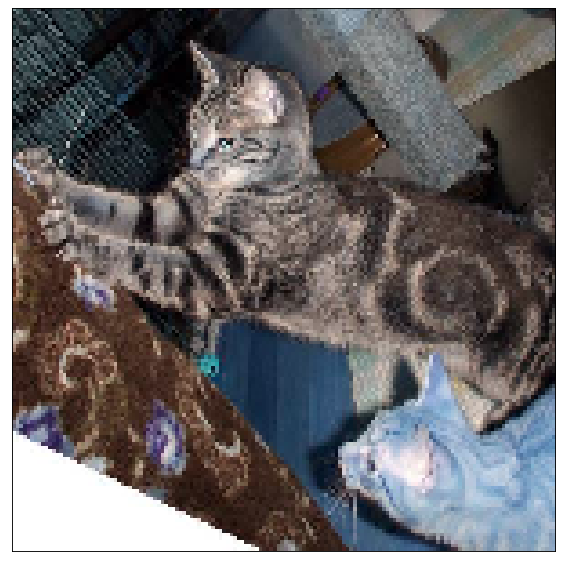

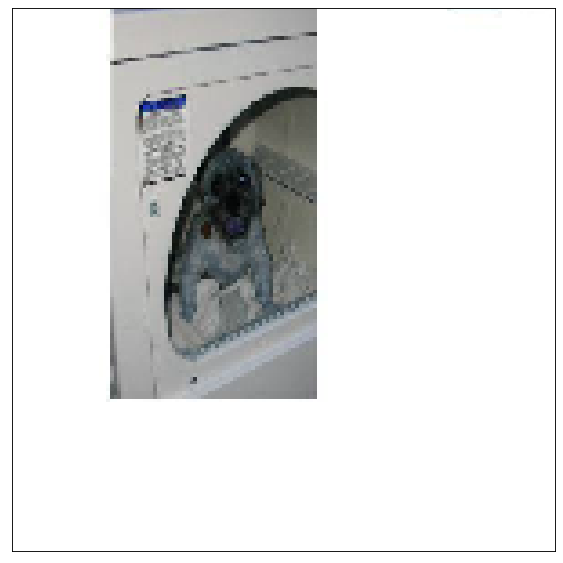

In [268]:
if use_graph:
    figure(figsize=(16, 9), dpi=80)
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    print(f"cat.{index + dataset_from}.jpg")
    figure(figsize=(16, 9), dpi=80)
    plt.imshow(cv2.cvtColor(images[100 + index], cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    print(f"dog.{index + dataset_from}.jpg")
    plt.show()

Я тоже с трудом могу сказать, что изображено на фотографиях.

Посмотрим, в чём наша нейронка уверена в большей степени.

In [274]:
shure_cat = np.argmin(predictions)
shure_dog = np.argmax(predictions)

print(f"Prediction for cat.{dataset_from + shure_cat}.jpg: {float('{:.2f}'.format(1.0 - predictions[shure_cat][0]))}")
print(f"Prediction for dog.{dataset_from + shure_dog - 100}.jpg: {float('{:.2f}'.format(predictions[shure_dog][0]))}")

Prediction for cat.10952.jpg: 1.0
Prediction for dog.10998.jpg: 1.0


cat.10952.jpg
dog.10998.jpg


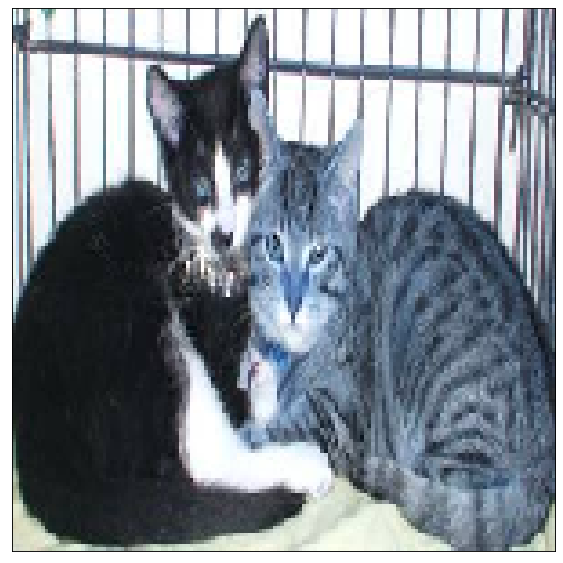

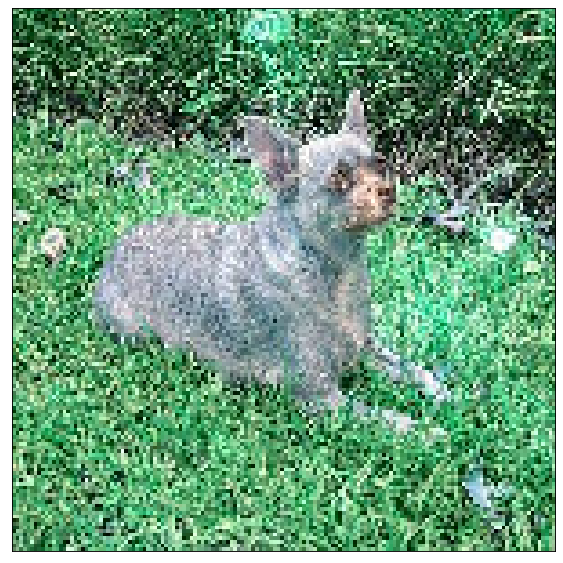

In [271]:
if use_graph:
    figure(figsize=(16, 9), dpi=80)
    plt.imshow(cv2.cvtColor(images[shure_cat], cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    print(f"cat.{dataset_from + shure_cat}.jpg")
    figure(figsize=(16, 9), dpi=80)
    plt.imshow(cv2.cvtColor(images[shure_dog], cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    print(f"dog.{dataset_from + shure_dog - 100}.jpg")
    plt.show()